Note: **I am a data scientist in the Bay Area!  Feel free to contact me with questions, concerns, offers for work ;)**

- [trevor.m.murphy@gmail.com](mailto:trevor.m.murphy@gmail.com)
- [LinkedIn](https://www.linkedin.com/in/trevor-murphy-49ba1421)
- [GitHub](https://github.com/tmurph)

# Classification of Player Characters in Super Smash Bros. Melee

This notebook contains the code and resources to recognize the most common player avatars (hereafter, characters) used by professional players of the competitive fighting game Super Smash Bros. Melee.

A neural network is given images captured from scripted game play and trained via transfer learning from VGG16.  In tests the network achieves ~96% accuracy after ~15 training epochs.

## Transfer Learning Code

### Training Data

Let’s have a look at some of the images used to train the CNN.  These images were captured from scripted gameplay.  The [Data Generation](smash.org) section includes technical details on the capturing process.

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]

In [ ]:
import os
import re
import cv2

DATA_DIR = "data/keras"

all_images = []
for root, dirs, files in os.walk(os.path.join(DATA_DIR, 'train', 'images')):
    all_images.extend(files)

img_re = re.compile('(?:[^/]*/)*'
                    '(?P<character>[^_]*)_'
                    '(?P<color>[^_]*)_'
                    '(?P<stage>[^_]*)_'
                    '(?P<orientation>[^_]*)_'
                    'bg_on_'
                    '(?P<img_number>[0-9]{3})'
                    '.jpg')

def get_image(character, color, stage, orientation, img_number):
    image = os.path.join(DATA_DIR, 'train', 'images', character, f'{character}_{color}_{stage}_{orientation}_bg_on_{img_number}.jpg')

    bgr_image = cv2.imread(image)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    return rgb_image

def get_image_by_name(name):
    image_groups = re.search(img_re, name)
    return get_image(**image_groups.groupdict())

IMAGE_ROW_SIZE, IMAGE_COLUMN_SIZE, IMAGE_DEPTH = get_image_by_name(all_images[0]).shape

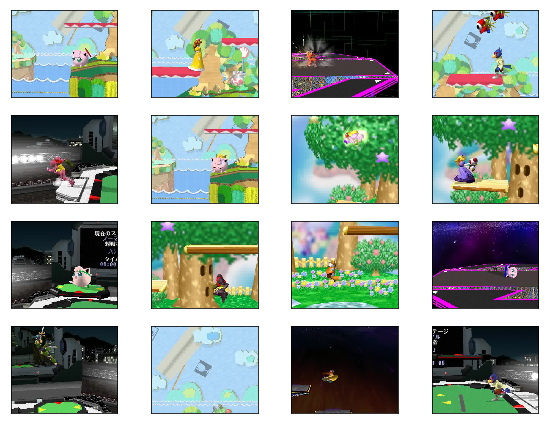

In [ ]:
import random

NUM_ROWS = 4
NUM_COLS = 4

fig, axarr = plt.subplots(NUM_ROWS, NUM_COLS, sharex=True, sharey=True, squeeze=False)

for i, image_name in enumerate(random.sample(all_images, NUM_ROWS * NUM_COLS)):
    ax = axarr[divmod(i, NUM_COLS)]
    ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax.imshow(get_image_by_name(image_name))

fig.tight_layout()

Some relevant limitations of this data set:

- characters rarely fill more than 10% of the image
- characters contort into a wide variety of poses
- the same character can appear in a variety of color palettes
- visual effects such as smoke and explosions frequently occlude parts of the characters
- depending on color palette, characters may blend into the background

Nevertheless, VGG16 is able to extract useful features and accurately classify which character is featured in which image.

### Feature Extraction

Because VGG16 is very computationally expensive to run, and because we won’t actually adjust any of the weights or biases of the convolutional layers, we can save on training computation by running VGG16 once over our images to extract features.  This demands a lot of memory, but it enables us to rapidly train, test, and tweak subsequent classification models.

The following code blocks set up the model.

In [ ]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.utils import multi_gpu_model
from keras.models import clone_model
from GPUtil import getGPUs

try:
    NUM_GPU = len(getGPUs())
except:
    NUM_GPU = 0

def gpuify_model_maybe(model):
    result = None
    if NUM_GPU >= 2:
        result = multi_gpu_model(model, gpus=NUM_GPU)
    elif NUM_GPU == 1:
        with tf.device("/gpu:0"):
            result = clone_model(model)
    else:
        result = model
    return result

In [ ]:
with tf.device("/cpu:0"):
    vgg_model = VGG16(include_top=False, weights="imagenet", input_shape=(IMAGE_ROW_SIZE, IMAGE_COLUMN_SIZE, IMAGE_DEPTH))
vgg_model = gpuify_model_maybe(vgg_model)

The following code blocks set up the data flow into the model.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

BATCH_SIZE = 16 * max(NUM_GPU, 1)

def make_generator(folder="train",
                   data_gen_args={"fill_mode": "constant",
                                  "cval": 0,
                                  "width_shift_range": 0.05,
                                  "height_shift_range": 0.05,
                                  "zoom_range": 0.1,
                                  "horizontal_flip": True,
                                  "preprocessing_function": preprocess_input},
                   data_flow_args={"seed": 1,
                                   "batch_size": BATCH_SIZE}):

    image_datagen = ImageDataGenerator(**data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        directory=os.path.join(DATA_DIR, folder, "images"),
        target_size=(IMAGE_ROW_SIZE, IMAGE_COLUMN_SIZE),
        color_mode='rgb',
        **data_flow_args)

    return image_generator

def truncate_generator(gen, limit=None):
    i = 0
    for elt in gen:
        if limit and i < limit:
            yield elt
            i += 1
        else:
            return

We’re going to run VGG16 over our images in non-random order.  The `model.predict_generator` API requires a generator that emits solely arrays of images (as opposed to pairs like `(image_array, label_array)`).  We use `class_mode: None` and `shuffle: False` to get the appropriate generator.

In [ ]:
image_generator_train = make_generator("train", data_gen_args={"preprocessing_function": preprocess_input},
                                       data_flow_args={"batch_size": BATCH_SIZE, "class_mode": None, "shuffle": False})

We also need to extract the labels for our images in the same non-random order.  So we create another generator with `shuffle: False` but without `class_mode: None`.

In [ ]:
label_generator_train = make_generator("train", data_gen_args={}, data_flow_args={"batch_size": BATCH_SIZE, "shuffle": False})

Now we run our feature extraction code.  We’ll get two arrays, one of labels, the other of image feature data.

In [ ]:
def count_images(folder="train"):
    image_directory = os.path.join(DATA_DIR, folder, "images")
    data_size = 0

    for char_name in os.listdir(image_directory):
        char_directory = os.path.join(image_directory, char_name)
        data_size += len(os.listdir(char_directory))

    return data_size

In [ ]:
image_count_train = count_images("train")
image_count_train_generator_cutoff = image_count_train / BATCH_SIZE + 1

train_labels = []
for _, labels in truncate_generator(label_generator_train, image_count_train_generator_cutoff):
    train_labels.extend(labels)
train_labels = np.array(train_labels[:image_count_train])

train_data = vgg_model.predict_generator(image_generator_train, steps=image_count_train_generator_cutoff)
train_data = train_data[:image_count_train]

Let’s generate the equivalent arrays for our validation data.  

In [ ]:
image_count_valid = count_images("valid")
image_count_valid_generator_cutoff = image_count_valid / BATCH_SIZE + 1

image_generator_valid = make_generator("valid", data_gen_args={"preprocessing_function": preprocess_input},
                                       data_flow_args={"batch_size": BATCH_SIZE, "class_mode": None, "shuffle": False})
label_generator_valid = make_generator("valid", data_gen_args={}, data_flow_args={"batch_size": BATCH_SIZE, "shuffle": False})

valid_labels = []
for _, labels in truncate_generator(label_generator_valid, image_count_valid_generator_cutoff):
    valid_labels.extend(labels)
valid_labels = np.array(valid_labels[:image_count_valid])

feature_data = vgg_model.predict_generator(image_generator_valid, steps=image_count_valid_generator_cutoff)
feature_data = feature_data[:image_count_valid]

Our arrays are in non-random order.  Before we can train our small neural network we need to randomize the data.

In [ ]:
train_randomizer = np.arange(train_data.shape[0])
np.random.shuffle(train_randomizer)
train_data = train_data[train_randomizer]
train_labels = train_labels[train_randomizer]

valid_randomizer = np.arange(valid_data.shape[0])
np.random.shuffle(valid_randomizer)
valid_data = valid_data[valid_randomizer]
valid_labels = valid_labels[valid_randomizer]

It’s almost show time.  We’ll build our model in a CPU environment but compile it for a GPU environment.

In [ ]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense

LEARNING_RATE = 0.0001
NUM_CHARACTERS = len(os.listdir(os.path.join(DATA_DIR, "train", "images")))

def build_model(input_shape, target_num=NUM_CHARACTERS, hidden_width=128, hidden_depth=1, dropout_rate=0.2):
    with tf.device("/cpu:0"):
        model = Sequential()
        model.add(Flatten(input_shape=input_shape))
        for _ in range(hidden_depth):
            model.add(Dense(hidden_width, activation='relu', kernel_initializer='lecun_uniform'))
            model.add(Dropout(dropout_rate))
        model.add(Dense(target_num, activation='softmax'))

    return model

def compile_model(model, learning_rate=LEARNING_RATE):
    model = gpuify_model_maybe(model)
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

We want to use these callbacks to ensure early stopping in case of a bad model, and to improve learning as the model reaches diminishing returns.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

stop_on_val_loss = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=3, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

Time to train!

In [ ]:
template_model = build_model(train_data.shape[1:], hidden_width=512, hidden_depth=3, dropout_rate=0.2)
compiled_model = compile_model(template_model)

training_history = compiled_model.fit(train_data, train_labels,
                                      epochs=15,
                                      batch_size=BATCH_SIZE,
                                      validation_data=(valid_data, valid_labels),
                                      callbacks=[stop_on_val_loss, reduce_lr])

Per a bug in Keras, we can’t actually save the `compiled_model` object to disk.  However, all the structure and learned weights of the `compiled_model` object are shared with the `template_model` object, so we can use that variable instead.

The `template_model` object is not very useful for practical classification, however, since it expects an array of VGG16 features.  Before we save our progress we must stack the `template_model` on top of VGG16.

In [ ]:
from keras.models import Model
import datetime

full_model = Model(inputs=vgg_model.input, outputs=template_model(vgg_model.output))
full_model.save(os.path.join(DATA_DIR, datetime.datetime.today().strftime('%Y-%m-%d-%H-%M') + "-model.h5"))

Time to run our full model on test data and see how we do!

In [ ]:
image_count_test = count_images("test")
image_count_test_generator_cutoff = image_count_test / BATCH_SIZE + 1

image_generator_test = make_generator("test", data_gen_args={"preprocessing_function": preprocess_input},
    data_flow_args={"batch_size": BATCH_SIZE, "class_mode": None, "shuffle": False})
label_generator_test = make_generator("test", data_gen_args={}, data_flow_args={"batch_size": BATCH_SIZE, "shuffle": False})

In [ ]:
true_labels = []
for _, labels in truncate_generator(label_generator_test, image_count_test_generator_cutoff):
    true_labels.extend(labels)
true_labels = np.array(true_labels[:image_count_test])
true_classes = true_labels.argmax(1)

In [ ]:
pred_labels = full_model.predict_generator(image_generator_test, steps=image_count_test_generator_cutoff)
pred_labels = pred_labels[:image_count_test]
pred_classes = pred_labels.argmax(1)

In [ ]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(true_classes, pred_classes)

And now we can visualize our progress!

In [ ]:
import itertools

def plot_confusion_matrix(matrix, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We could visualize the confusion matrix over abstract numeric representations of classes … but with a little digging we can find the actual class names as taken from the folder hierarchy.

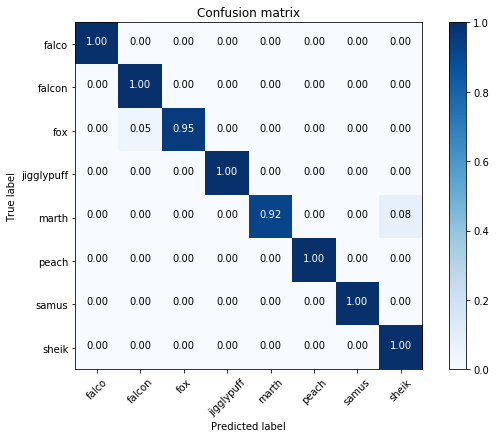

In [ ]:
class_names = [c for c, i in sorted(label_generator_test.class_indices.items(), key=lambda pair: pair[1])]

plot_confusion_matrix(c_matrix, class_names, normalize=True)

## Discussion